In [1]:
from data.image_dataset import ImageDataset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset


dataset = ImageDataset('../datasets/UNet_train/', transform=transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
]))

# sub = Subset(dataset, range(300))

dataloader = DataLoader(dataset, batch_size=16, shuffle=True,
                        num_workers=16, prefetch_factor=2)

In [5]:
from model.unet.facediffusion_unet import FaceDiffusionUNet
from model.unet.blocks.time_embedding import encode_timesteps
from model.vae.vae import VAE
import torch
import matplotlib.pyplot as plt
from torchinfo import summary

unet = FaceDiffusionUNet().cuda()
unet.load_state_dict(torch.load("../runs/unet_vae_tune3/unet.safetensors"))
vae = VAE()
vae.load_state_dict(torch.load("../runs/vae_base_nighttune/vae.safetensors"))
vae.eval()

summary(unet)

Layer (type:depth-idx)                             Param #
FaceDiffusionUNet                                  --
├─TimeEmbedding: 1-1                               --
│    └─Linear: 2-1                                 410,880
│    └─Linear: 2-2                                 1,639,680
├─UNet: 1-2                                        --
│    └─ModuleList: 2-3                             --
│    │    └─SwitchSequential: 3-1                  2,960
│    │    └─SwitchSequential: 3-2                  334,800
│    │    └─SwitchSequential: 3-3                  334,800
│    │    └─SwitchSequential: 3-4                  57,680
│    │    └─SwitchSequential: 3-5                  1,028,000
│    │    └─SwitchSequential: 3-6                  1,130,400
│    │    └─SwitchSequential: 3-7                  230,560
│    │    └─SwitchSequential: 3-8                  3,694,400
│    │    └─SwitchSequential: 3-9                  4,104,000
│    │    └─SwitchSequential: 3-10                 921,920
│    │    

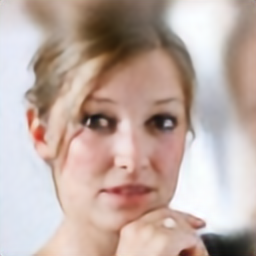

In [6]:
from diffusers import DDPMScheduler
from PIL import Image
import matplotlib.pyplot as plt
from data.utils import tensor_to_images

with torch.no_grad():
    sample_image = dataset[100]
    seed = torch.normal(0, 1, size=(1, 4, 32, 32))
    noise_scheduler = DDPMScheduler(1000)
    latent = vae.encoder(sample_image.unsqueeze(0), seed)[0]
    noise = torch.randn(latent.shape)
    noisy_latent = noise_scheduler.add_noise(
        latent, noise, timesteps=torch.LongTensor([0]))

    noisy_image = vae.decoder(noisy_latent)


tensor_to_images(sample_image.unsqueeze(0))[0]
tensor_to_images(noisy_image)[0]

In [ ]:
from torch.optim import Adam
from torch.nn import MSELoss
from diffusers import get_cosine_schedule_with_warmup

epochs = 30
optimizer = Adam(unet.parameters(), lr=1e-9)
lr_scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=500, num_training_steps=len(dataloader) * epochs)
criterion = MSELoss()

In [ ]:
from pipelines.unet_training import UNetTrainingPipeline

pipeline = UNetTrainingPipeline(
    unet=unet,
    vae=vae,
    dataloader=dataloader,
)

pipeline.train('unet_vae_tune4', '../runs/', epochs,
               optimizer=optimizer, lr_scheduler=lr_scheduler, sample_period=1)

KeyboardInterrupt: 

  0%|          | 0/30 [00:00<?, ?it/s]

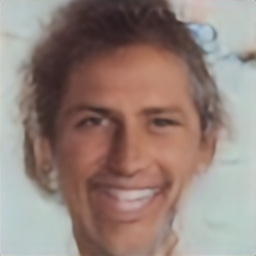

In [32]:
from diffusers.schedulers import DPMSolverSinglestepScheduler, EulerDiscreteScheduler, DPMSolverMultistepScheduler, DDPMScheduler
from model.unet.facediffusion_unet import FaceDiffusionUNet
from model.unet.blocks.time_embedding import encode_timesteps
from tqdm.auto import tqdm
from data.utils import tensor_to_images
from model.vae.vae import VAE
import torch

# scheduler = DPMSolverSinglestepScheduler(
#     1000, solver_order=3, lower_order_final=True, use_karras_sigmas=True)
# scheduler = DPMSolverMultistepScheduler(1000, solver_order=3, use_karras_sigmas=True)
scheduler = DDPMScheduler(1000)
scheduler.set_timesteps(30)
latent = torch.normal(0, 1, (1, 4, 32, 32)).cuda()
model = FaceDiffusionUNet().cuda()
state_dict = torch.load('../runs/unet_vae_tune3/unet.safetensors')
model.load_state_dict(state_dict)

model.eval()
with torch.no_grad():
    for t in tqdm(scheduler.timesteps):
        pred_noise = model(latent, encode_timesteps(torch.Tensor([t])).cuda())
        latent = scheduler.step(pred_noise, t, latent).prev_sample

vae = VAE().cuda()
vae.load_state_dict(torch.load("../runs/vae_base_nighttune/vae.safetensors"))
imgs = vae.decoder(latent)
imgs = tensor_to_images(imgs)
imgs[0]

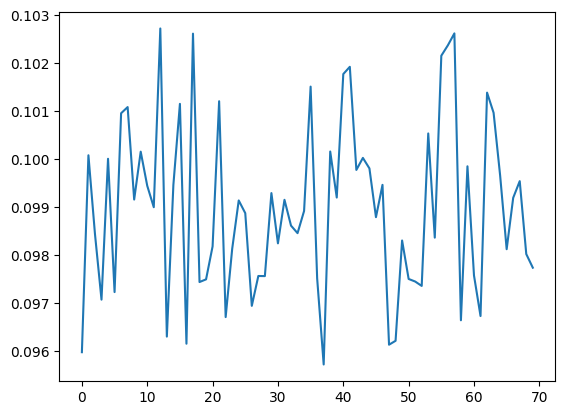

In [7]:
import matplotlib.pyplot as plt
import json

with open('../runs/unet_vae_tune3/loss.json') as f:
    loss = json.load(f)

plt.plot(loss)